In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

In [2]:
os.chdir('../')
print("Current working directory:", os.getcwd())

Current working directory: f:\GP\sem 2\MIMO GAN\project


In [3]:
from src.model_builder import Generator
from eval.eval import *
from src.model_utils import prepare_tensor_for_conv, mimo_conv_batched

In [4]:
# simulation params
L = 23
Nr = Nt = 4
NUM_ANTENNA_PAIRS = Nr * Nt
z_dim = 50
EMBED_DIM = 4
HIDDEN_DIM = 100
BATCH_SIZE = 12000

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Create an instance of the model
model = Generator(Nr, Nt, L, z_dim, EMBED_DIM, HIDDEN_DIM).to(device)
model = model.double()
# Load the state dictionary
state_dict = torch.load(os.path.join('models', 'G_B0L1_BSZ512_EMB4_Z50_LKY.pt'))
model.load_state_dict(state_dict)

model.eval()

Generator(
  (embedding): Linear(in_features=16, out_features=4, bias=True)
  (main): Sequential(
    (0): Linear(in_features=54, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=46, bias=True)
  )
)

In [7]:
# get a batch of generated data
H = get_batch_generated(model, BATCH_SIZE, Nr, Nt, L, z_dim, device)

In [8]:
power = torch.sum(torch.pow(torch.abs(H),2), dim=(1,3), keepdim=True)
H_n = H / torch.sqrt(power)

In [18]:
# setting up transmitted signal - unit power discrete impulse
T = 128

input_signal = torch.zeros(1, Nt, T, device=device, dtype=torch.complex128)
input_signal[0,0,0] = 1
input_signal[0,1,12] = 1
input_signal[0,2,25] = 1
input_signal[0,3,39] = 1

sample_indices = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 17, 19, 20, 22, 23, 28, 35, 38, 42, 44, 46, 49, 89], device=device)

In [19]:
channel_tensor = prepare_tensor_for_conv(H_n, sample_indices).flip(dims=[-1])

output_signal = mimo_conv_batched(input_signal, channel_tensor) # shape [BATCH_SIZE, Nr, T]

output_signal = output_signal.cpu().numpy()

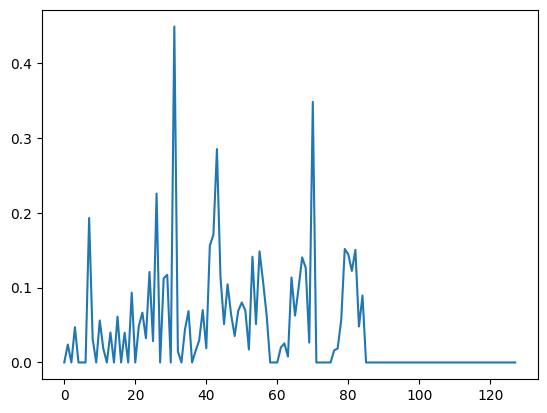

In [20]:
plt.figure()
plt.plot(np.abs(output_signal[2000,0,:]))
plt.show()